In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [4]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

In [6]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Perform a calculation using the input
result = 2*input + 1

# the result doesn't have a value
result

<KerasTensor shape=(None,), dtype=float32, sparse=False, name=keras_tensor_2>

In [7]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [8]:
print(calc(np.array([1])).numpy())
print(calc(np.array([2])).numpy())

[3.]
[5.]


2025-01-24 20:57:11.838783: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'sex': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=sex>,
 'age': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=age>,
 'n_siblings_spouses': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=n_siblings_spouses>,
 'parch': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=parch>,
 'fare': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=fare>,
 'class': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=class>,
 'deck': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=deck>,
 'embark_town': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=embark_town>,
 'alone': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=alone>}

In [10]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_4>

In [11]:
preprocessed_inputs = [all_numeric_inputs]

In [12]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

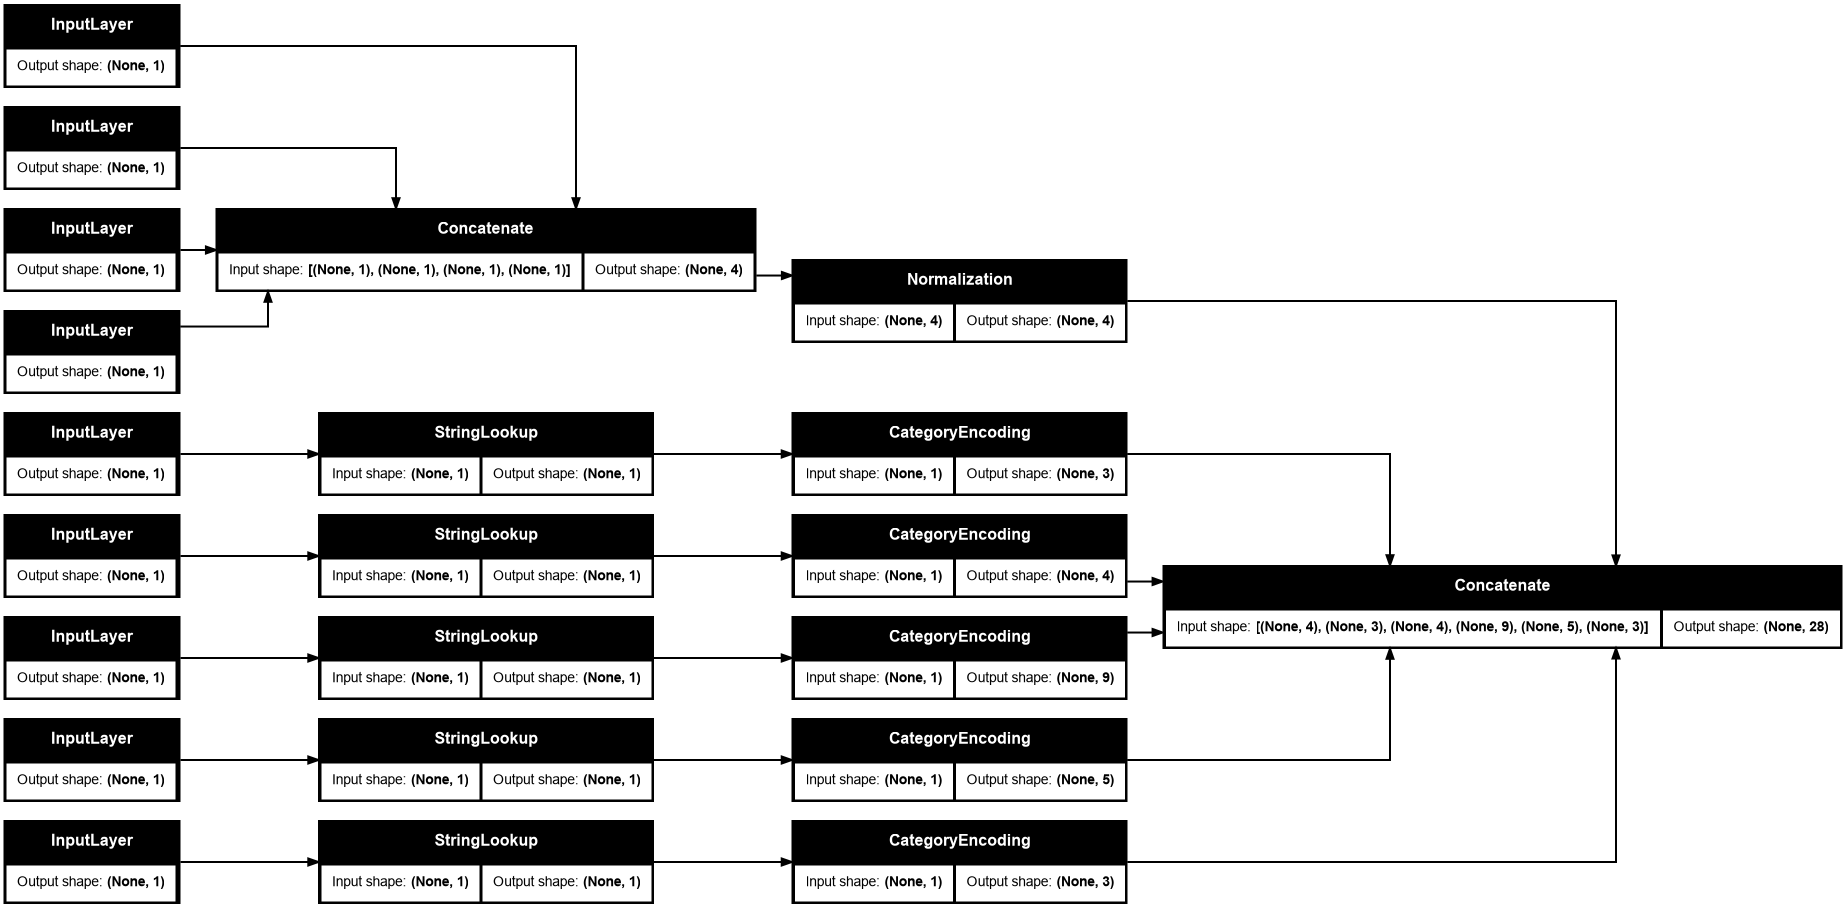

In [13]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [14]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

In [15]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[-0.6104149 ,  0.39519805, -0.4790527 , -0.4974028 ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ]], dtype=float32)>

In [16]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam())
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

In [21]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=100)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.3094
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.3101
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.3012
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.2907
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.3139
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.3046
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.3203
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 0.2944
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.2878
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 0.2810
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.3146
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.2869
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 0.3221
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.3010
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 